In [1]:
import numpy as np
import glob, os, sys
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz
from scipy.ndimage import binary_erosion, generate_binary_structure
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# For non-gui back end
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
#-----------------------------------------------------------------------
def label_perimeter(tracknumber):
    """
    Labels the perimeter on a 2D map from cell tracknumbers.
    """
    
    # Generate a cross structure
    dilationstructure = generate_binary_structure(2,1)
    
    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)

    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)
    
    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the cell mask
        itn = tracknumber == ii
        # Erode the cell by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the cell number
        tracknumber_perim[iperim == 1] = ii
    
    return tracknumber_perim

#-----------------------------------------------------------------------
def calc_cell_center(tracknumber, longitude, latitude, xx, yy):
    """
    Calculates the center location from labeled cells.
    """
    
    # Find unique tracknumbers
    tracknumber_uniqe = np.unique(tracknumber[~np.isnan(tracknumber)])
    num_tracknumber = len(tracknumber_uniqe)
    # Make arrays for cell center locations
    lon_c = np.full(num_tracknumber, np.nan, dtype=float)
    lat_c = np.full(num_tracknumber, np.nan, dtype=float)
    xx_c = np.full(num_tracknumber, np.nan, dtype=float)
    yy_c = np.full(num_tracknumber, np.nan, dtype=float)

    # Loop over each tracknumbers to calculate the mean lat/lon & x/y for their center locations
    for ii, itn in enumerate(tracknumber_uniqe):
        iyy, ixx = np.where(tracknumber == itn)
        # lon_c[ii] = np.mean(longitude[iyy, ixx])
        # lat_c[ii] = np.mean(latitude[iyy, ixx])
        lon_c[ii] = np.mean(longitude[tracknumber == itn])
        lat_c[ii] = np.mean(latitude[tracknumber == itn])
        xx_c[ii] = np.mean(xx[ixx])
        yy_c[ii] = np.mean(yy[iyy])
        
    return lon_c, lat_c, xx_c, yy_c, tracknumber_uniqe

#-----------------------------------------------------------------------
def calc_latlon(lon1, lat1, dist, angle):
    """
    Haversine formula to calculate lat/lon locations from distance and angle.
    
    lon1:   longitude in [degree]
    lat1:   latitude in [degree]
    dist:   distance in [km]
    angle:  angle in [degree]
    """

    import math

    # Earth radius
    # R_earth = 6378.39  # at Equator [km]
    R_earth = 6374.2  # at 40 degree latitude [km]
#     R_earth = 6356.91  # at the pole [km]

    # Conver degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(angle)

    lat2 = math.asin(math.sin(lat1) * math.cos(dist/R_earth) +
                     math.cos(lat1) * math.sin(dist/R_earth) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(dist/R_earth) * math.cos(lat1),
                             math.cos(dist/R_earth) - math.sin(lat1) * math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lon2, lat2

#-----------------------------------------------------------------------
def compute_basetime(datetime_string):
    """
    Calculates base time from date/time string
    ----------
    datetime_string: string
        date/time string: yyyymmdd.hhmmss
    
    Returns
    ----------
    bt: int
        Base time in Epoch.
    """
    year = int(datetime_string[0:4])
    month = int(datetime_string[4:6])
    day = int(datetime_string[6:8])
    hour = int(datetime_string[9:11])
    minute = int(datetime_string[11:13])
    second = int(datetime_string[13:15])
    
    bt = calendar.timegm(datetime.datetime(year, month, day, hour, minute, second, tzinfo=pytz.UTC).timetuple())
    
    return bt

In [7]:
input_dates = '20190125.2000'

# Minimum time difference between RHI and PPI [minute]
dt_thresh = 10
    
terrainfile = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/CACTI_rhi_gridded_50m_surface_elevation.nc'

rootdir = '/global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/'
# rootdir = os.path.expandvars('$SCRATCH') + '/iclass/cacti/arm/csapr/'
ppidir = f'{rootdir}taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/'
rhidir = f'{rootdir}taranis_corcsapr2cfrhsrhiqcM1_gridded.c1/'
ppibasename = 'taranis_corcsapr2cfrppiqcM1_convmask.c1.'
rhibasename = 'taranis_corcsapr2cfrhsrhiqcM1.c1.'
ppifiles = sorted(glob.glob(f'{ppidir}{ppibasename}{input_dates}*.nc'))
rhifiles = sorted(glob.glob(f'{rhidir}{rhibasename}*nc'))
print(f'Number of PPI files: {len(ppifiles)}')

figdir = f'{rhidir}quicklooks/'
os.makedirs(figdir, exist_ok=True)

Number of PPI files: 1


In [8]:
# Calculates basetime from RHI file names
nrhifiles = len(rhifiles)
rhi_basetimes = np.zeros(nrhifiles, dtype=int)
for ii in range(nrhifiles):
    idatetime = os.path.basename(rhifiles[ii])[len(rhibasename):len(rhibasename)+15]
    rhi_basetimes[ii] = compute_basetime(idatetime)

# Find matching RHI file for each PPI file
# rhifiles_match = np.full(len(ppifiles), "", dtype=f'S{len(rhifiles[0])}')
# rhidatetimes_match = np.full(len(ppifiles), "", dtype=f'S17')
rhifiles_match = np.full(len(ppifiles), "", dtype='object')
rhidatetimes_match = np.full(len(ppifiles), "", dtype='object')
for ifile in range(len(ppifiles)):
    # Calculate PPI basetime
    datetime_str = os.path.basename(ppifiles[ifile])[len(ppibasename):len(ppibasename)+15]
    ppi_bt = compute_basetime(datetime_str)

    # Find the closest RHI time
    tdiff = np.abs(rhi_basetimes - ppi_bt)
    idx_match = np.argmin(tdiff)

    # Proceed is time difference is < dt_thresh
    if tdiff[idx_match] < dt_thresh*60:

        rhi_bt = rhi_basetimes[idx_match]
        rhidatetimes_match[ifile] = pd.to_datetime(rhi_bt, unit='s').strftime("%Y%m%d.%H%M%S")
        rhifiles_match[ifile] = rhifiles[idx_match]
        # print(f'PPI: {datetime_str}, HSRHI: {rhidatetimes_match}')

In [9]:
rhifiles_match

array(['/global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/taranis_corcsapr2cfrhsrhiqcM1_gridded.c1/taranis_corcsapr2cfrhsrhiqcM1.c1.20190125.195600_gridded.nc'],
      dtype=object)

In [10]:
# datetime_str = os.path.basename(ppifiles[0])[len(ppibasename):len(ppibasename)+15]
# ppi_bt = compute_basetime(datetime_str)
# print(datetime_str, ppi_bt)

In [11]:
# # Find RHI files on the same date (may not be the best way)
# ppidate = datetime_str[0:8]
# rhifiles = sorted(glob.glob(f'{rhidir}{rhibasename}{ppidate}*.nc'))
# nrhifiles = len(rhifiles)

# # Calculates Epoch time from file names
# rhi_bt = np.zeros(nrhifiles, dtype=int)
# for ii in range(nrhifiles):
#     idatetime = os.path.basename(rhifiles[ii])[len(rhibasename):len(rhibasename)+15]
#     rhi_bt[ii] = compute_basetime(idatetime)

In [12]:
# pd.to_datetime(ppi_bt, unit='s').strftime("%Y%m%d.%H%M%S")
# pd.to_datetime(ppi_bt, unit='s') + pd.Timedelta(minutes=15)

In [15]:
# # Read PPI file
# ds = xr.open_dataset(ppifiles[0])
# ds

In [23]:
dst = xr.open_dataset(terrainfile)
dst

<xarray.Dataset>
Dimensions:         (angle: 6, h_distance: 4400)
Coordinates:
    longitude       (angle, h_distance) float64 ...
    latitude        (angle, h_distance) float64 ...
  * angle           (angle) int64 0 30 60 90 120 150
  * h_distance      (h_distance) int64 -110000 -109950 -109900 ... 109900 109950
Data variables:
    terrain_height  (angle, h_distance) float64 ...
Attributes:
    contact:  Joseph Hardin (josephhardinee@gmail.com)
    history:  Generated from 30m terrain, Linear Interpolation

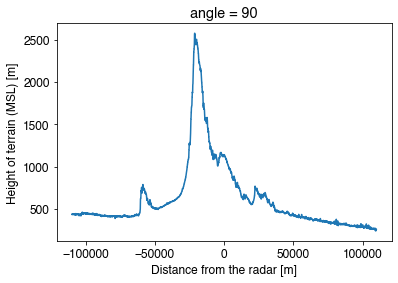

In [39]:
dst.sel(angle=90)['terrain_height'].plot()

In [43]:
radar_elev = dst['terrain_height'].sel(angle=90, h_distance=0).values

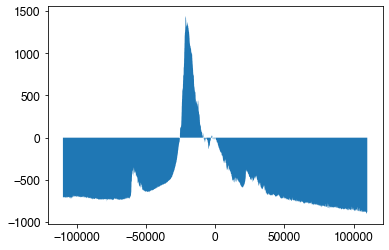

In [44]:
plt.fill_between(dst.h_distance, dst['terrain_height'].sel(angle=90)-radar_elev, 0)

In [17]:
# sweep = dsr.sweep
# dsr.taranis_attenuation_corrected_reflectivity.where(sweep == 30, drop=True).squeeze().plot(vmin=-10, vmax=60, cmap='gist_ncar')

In [18]:
ifile = 0
ppifile = ppifiles[ifile]
rhifile = rhifiles_match[ifile]

In [19]:
# Read data file
ds = xr.open_dataset(ppifile)
xx = ds.x.data
yy = ds.y.data
longitude = ds.longitude.data
latitude = ds.latitude.data

# Get conv_core and inflated convective mask
core = ds.conv_core.squeeze()
cn = ds.conv_mask_inflated.squeeze()
# Only plot if there is cell in the frame
if (np.nanmax(cn) > 0):
    # Get cell perimeters
    cn_perim = label_perimeter(cn.data)

    # Apply cellnumber to conv_mask
    conv1 = ds.conv_mask.squeeze()
    # cnconv1 = cn.where(conv1 > 0).data

    # Calculates cell center locations
    # lon_cn1, lat_cn1, xx_cn1, yy_cn1, cnconv1_uniqe = calc_cell_center(cnconv1, longitude, latitude, xx, yy)

    comp_ref = ds.dbz_comp.squeeze()
    levels = np.arange(-10, 60.1, 5)
    cbticks = np.arange(-10, 60.1, 5)
    cmaps = 'gist_ncar'
    titles = ['Convective Cells']
    cblabels = 'Reflectivity (dBZ)'
    ppi_timestr = ds.time.dt.strftime("%Y-%m-%d %H:%M UTC").data.item()

    # Read RHI file
    dsr = xr.open_dataset(rhifile)
    h_distance = dsr.h_distance/1000
    height = dsr.height/1000

    # Mask RHI data with quality mask
    rhi_ref_all = dsr.taranis_attenuation_corrected_reflectivity.where(dsr.data_quality_mask == 1)

In [60]:
def plot_ppi_rhi(xx, yy, comp_ref, tn_perim, core, rhi_xx, rhi_yy, rhi_ref, dst, 
                 levels, cmaps, titles, cblabels, cbticks, ppi_timestr, rhi_timestr, rhi_azimuth, figname):
    """
    Plot PPI and RHI.
    """

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    
    radii = np.arange(20,101,20)  # radii for the range rings [km]
    azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
    radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location
    
    map_extend = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]
    lonvals = mpl.ticker.FixedLocator(np.arange(-66,-63,0.5))
    latvals = mpl.ticker.FixedLocator(np.arange(-34,-30,0.5))
    proj = ccrs.PlateCarree()
    
    # Create an all black colormap
    colors = [(0, 0, 0), (0, 0, 0), (0, 0, 0)]
    cmap_name = 'all_black'
    cm_black = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors, N=3)
    
    fig = plt.figure(figsize=[15,5], dpi=200)

    gs = gridspec.GridSpec(1,2, height_ratios=[1], width_ratios=[0.34,0.66])
#     gs.update(left=0.05, right=0.94, top=0.88, bottom=0.05, wspace=0.23, hspace=0.1)
#     gs_left = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], height_ratios=[1], width_ratios=[1,0.03], wspace=0.05, hspace=0.1)
#     gs_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], height_ratios=[1], width_ratios=[1,0.015], wspace=0.05, hspace=0.1)
    gs.update(left=0.05, right=0.95, top=0.93, bottom=0.1, wspace=0.12, hspace=0.1)
    gs_left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0], height_ratios=[1], width_ratios=[1], wspace=0.05, hspace=0.1)
    gs_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], height_ratios=[1], width_ratios=[1,0.017], wspace=0.05, hspace=0.1)
    
    ##########################################################
    # Panel 1
    ##########################################################
    ax1 = plt.subplot(gs_left[0], projection=proj)
    ax1.set_title(f'PPI {ppi_timestr}', loc='left')
    ax1.set_extent(map_extend, crs=proj)
    ax1.set_aspect('auto', adjustable=None)
    gl = ax1.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0, zorder=5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = lonvals
    gl.ylocator = latvals
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Plot reflectivity
    cmap = plt.get_cmap(cmaps)
    norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    Cm = np.ma.masked_invalid(comp_ref)
    cf1 = ax1.pcolormesh(xx, yy, Cm, norm=norm_ref, cmap=cmap, transform=proj, zorder=1)
    # Overplot cell tracknumber perimeters
    Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
    Tn[Tn > 0] = 10
    tn1 = ax1.pcolormesh(xx, yy, Tn, shading='auto', cmap='gray', transform=proj, zorder=2)

    # Overplot cores
    core_mask = np.ma.masked_where(core == 0, core)
    cc1 = ax1.pcolormesh(xx, yy, core_mask, shading='nearest', vmin=0, vmax=1, cmap=cm_black, transform=proj, zorder=2, alpha=0.5)

    # Plot range circles around radar
    for ii in range(0, len(radii)):
        ax1.tissot(rad_km=radii[ii], lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='none', edgecolor='k', linewidth=0.6, zorder=3)
    # Plot azimuth lines
    for ii in range(0, len(azimuths)):
        ilon, ilat = calc_latlon(radar_lon, radar_lat, 200, azimuths[ii])
        ax1.plot([radar_lon,ilon], [radar_lat,ilat], color='k', lw=0.6, transform=ccrs.Geodetic(), zorder=5)
    # Plot HSRHI azimuth
    azlon1, azlat1 = calc_latlon(radar_lon, radar_lat, 100, rhi_azimuth)
    azlon2, azlat2 = calc_latlon(radar_lon, radar_lat, 100, rhi_azimuth+180)
    ax1.plot([radar_lon,azlon1], [radar_lat,azlat1], color='magenta', lw=5, transform=ccrs.Geodetic(), zorder=6, alpha=0.7)
    ax1.plot([radar_lon,azlon2], [radar_lat,azlat2], color='magenta', lw=5, transform=ccrs.Geodetic(), zorder=6, alpha=0.7)
    
#     # Reflectivity colorbar
#     cax1 = plt.subplot(gs_left[1])
#     cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks)
    
    ##########################################################
    # Panel 2
    ##########################################################
    ax2 = plt.subplot(gs_right[0])
    radar_elev = dst['terrain_height'].sel(angle=rhi_azimuth, h_distance=0).values/1000
    Cm = np.ma.masked_invalid(rhi_ref)
    cf2 = ax2.pcolormesh(rhi_xx, rhi_yy+radar_elev, Cm, shading='nearest', norm=norm_ref, cmap=cmap, zorder=1)
    ax2.set_xlabel('Horizontal Distance (km)')
    ax2.set_ylabel('Height ASL (km)')
    ax2.grid(ls='--')
    ax2.set_ylim(0, 20)
    ax2.set_xlim(-100, 100)
    ax2.set_xticks(np.arange(-100,100.1,20))
    ax2.set_yticks(np.arange(0,20.1,2))
    # Overplot terrain    
    ter = ax2.fill_between(dst['h_distance']/1000, (dst['terrain_height'].sel(angle=rhi_azimuth))/1000, 0, color='gray', zorder=2)
    
    # Reflectivity colorbar
    cax2 = plt.subplot(gs_right[1])
    cb2 = plt.colorbar(cf2, cax=cax2, label=cblabels, ticks=cbticks)
    ax2.set_title(f'HSRHI (AZ: {rhi_azimuth}'+r'$\degree$)'+f' {rhi_timestr}', loc='left')    
    
    # Thread-safe figure output
    canvas = FigureCanvas(fig)
    canvas.print_png(figname)
    fig.savefig(figname, facecolor='w')
    return fig

/global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/taranis_corcsapr2cfrhsrhiqcM1_gridded.c1/quicklooks/ppi_rhi_20190125_195635_zh_30.png


/global/cfs/cdirs/m1867/zfeng/envs/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/global/cfs/cdirs/m1867/zfeng/envs/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/global/cfs/cdirs/m1867/zfeng/envs/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaae9841860

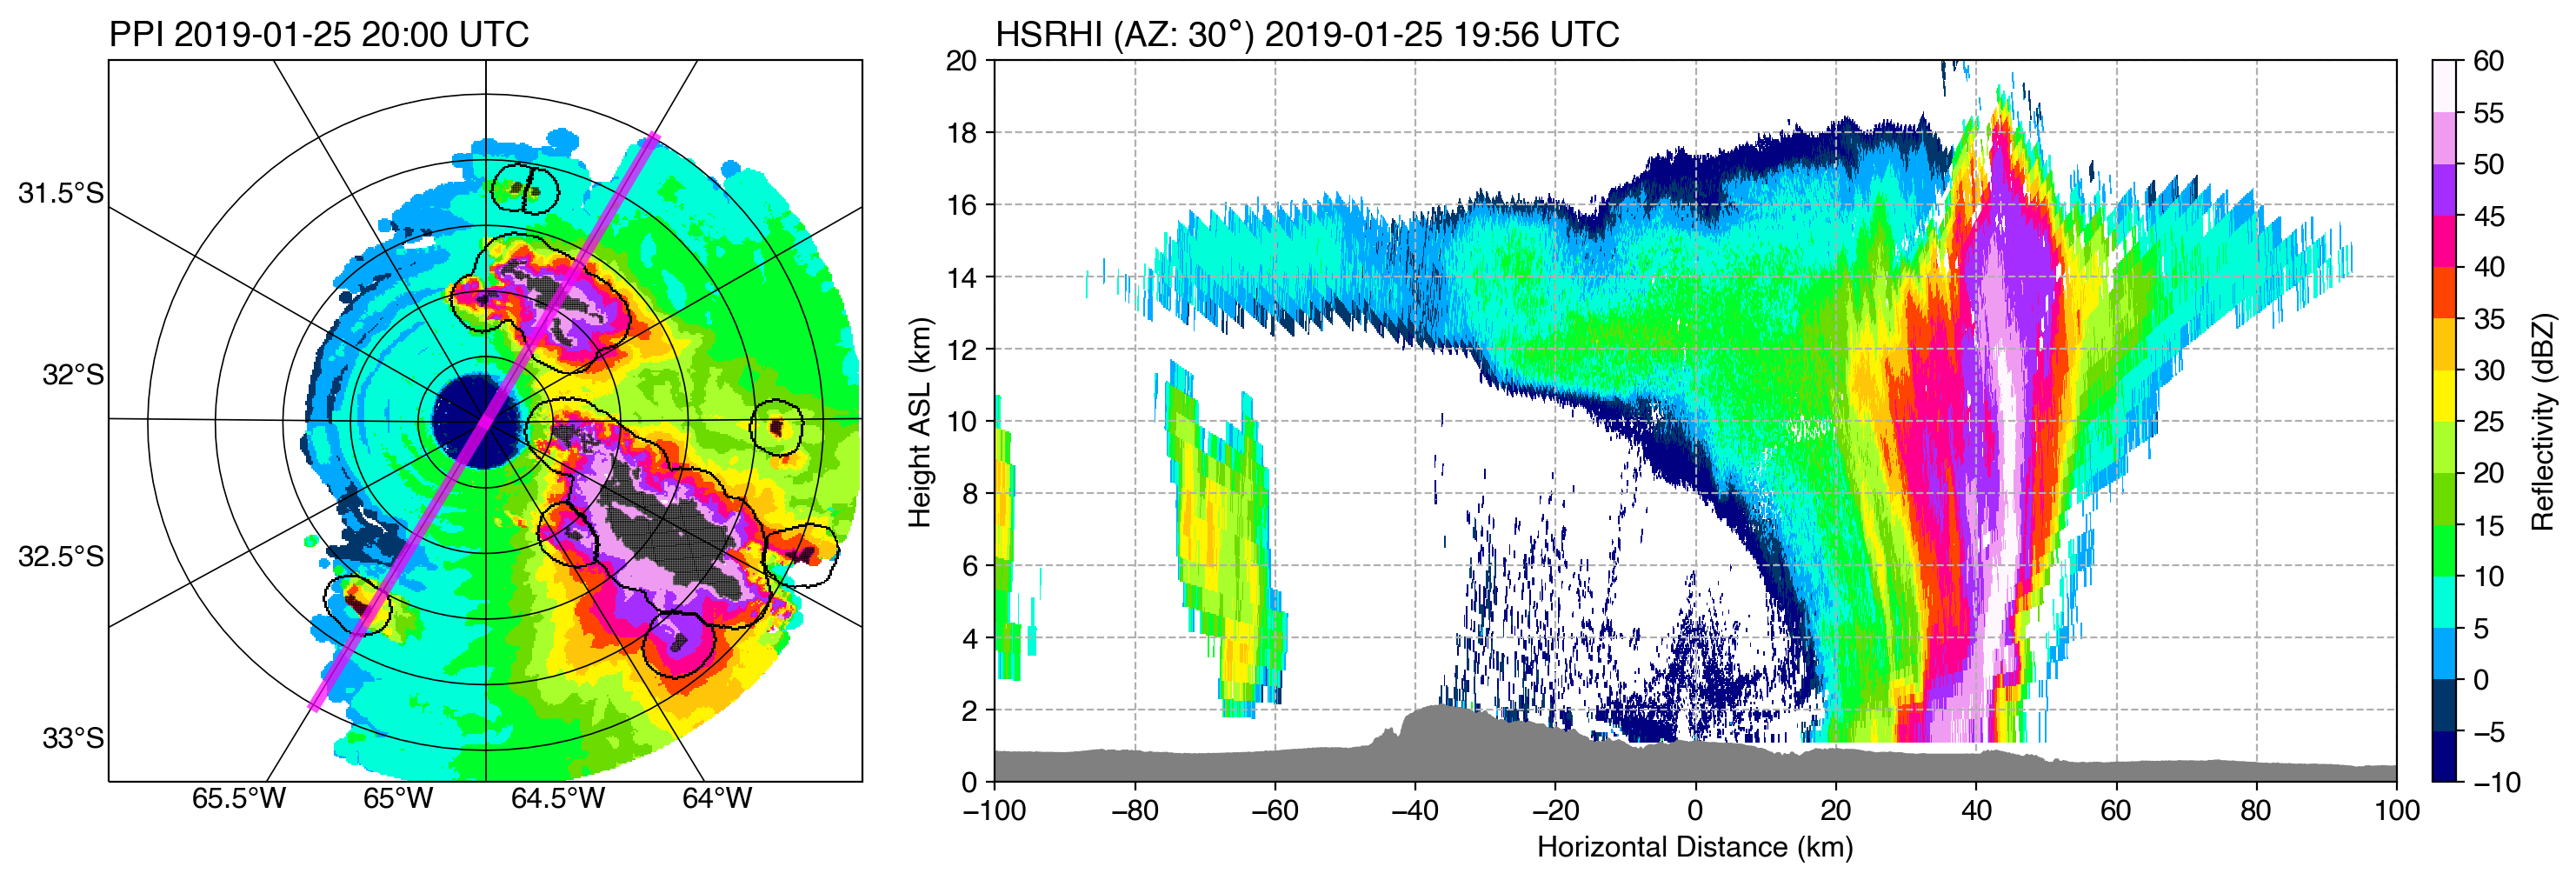

In [62]:
iaz = 1

iazimuth = dsr.sweep.values[iaz]
# Select specific azimuth
rhi_ref = rhi_ref_all.where(dsr.sweep == iazimuth, drop=True).squeeze().transpose()

# Convert RHI time string
btr = dsr.time.where(dsr.sweep == iazimuth, drop=True).values.item()
btr = np.round(btr).astype(int)
dtr = datetime.datetime.utcfromtimestamp(btr.astype('O'))
rhi_timestr = dtr.strftime("%Y-%m-%d %H:%M UTC")
fignametimestr = dtr.strftime("%Y%m%d_%H%M%S")
#     print(figtimestr)

figname = f'{figdir}ppi_rhi_{fignametimestr}_zh_{iazimuth:0.0f}.png'
print(figname)

# Call plotting function
fig = plot_ppi_rhi(longitude, latitude, comp_ref, cn_perim, core, h_distance, height, rhi_ref, dst, 
                    levels, cmaps, titles, cblabels, cbticks, ppi_timestr, rhi_timestr, iazimuth, figname)

In [ ]:
# dbz_rhi = dsr.taranis_attenuation_corrected_reflectivity.where(dsr.data_quality_mask == 1)
# idbz_rhi = dbz_rhi.where(sweep == 30, drop=True).squeeze().transpose()
# # idbz_rhi.plot(vmin=-10, vmax=60, cmap='gist_ncar')
# h_distance = dsr.h_distance/1000
# height = dsr.height

# cmap = plt.get_cmap('gist_ncar')
# levels = np.arange(-10, 60.1, 5)
# norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True) 
# plt.pcolormesh(h_distance, height, idbz_rhi, shading='auto', norm=norm_ref, cmap=cmap)
# plt.colorbar()

In [ ]:
# btr = dsr.time.where(sweep == 30, drop=True).values.item()
# btr = np.round(btr).astype(int)
# dtr = datetime.datetime.utcfromtimestamp(btr.astype('O'))
# rhi_timestr = dtr.strftime("%Y-%m-%d %H:%M:%S UTC")
# figtimestr = dtr.strftime("%Y%m%d_%H%M%S")
# print(figtimestr)

In [ ]:
# def plot_ppi_rhi(xx, yy, comp_ref, tn_perim, core, rhi_xx, rhi_yy, rhi_ref, 
#                  levels, cmaps, titles, cblabels, cbticks, ppi_timestr, rhi_timestr, rhi_azimuth, figname):
#     """
#     Plot PPI and RHI.
#     """

#     mpl.rcParams['font.size'] = 12
#     mpl.rcParams['font.family'] = 'Helvetica'
    
#     radii = np.arange(20,101,20)  # radii for the range rings [km]
#     azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
#     radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location
    
#     map_extend = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]
#     lonvals = mpl.ticker.FixedLocator(np.arange(-66,-63,0.5))
#     latvals = mpl.ticker.FixedLocator(np.arange(-34,-30,0.5))
#     proj = ccrs.PlateCarree()
    
#     # Create an all black colormap
#     colors = [(0, 0, 0), (0, 0, 0), (0, 0, 0)]
#     cmap_name = 'all_black'
#     cm_black = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors, N=3)
    
#     fig = plt.figure(figsize=[15,5], dpi=200)

#     gs = gridspec.GridSpec(1,2, height_ratios=[1], width_ratios=[0.34,0.66])
# #     gs.update(left=0.05, right=0.94, top=0.88, bottom=0.05, wspace=0.23, hspace=0.1)
# #     gs_left = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], height_ratios=[1], width_ratios=[1,0.03], wspace=0.05, hspace=0.1)
# #     gs_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], height_ratios=[1], width_ratios=[1,0.015], wspace=0.05, hspace=0.1)
#     gs.update(left=0.05, right=0.95, top=0.93, bottom=0.1, wspace=0.12, hspace=0.1)
#     gs_left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0], height_ratios=[1], width_ratios=[1], wspace=0.05, hspace=0.1)
#     gs_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], height_ratios=[1], width_ratios=[1,0.017], wspace=0.05, hspace=0.1)
    
#     ##########################################################
#     # Panel 1
#     ##########################################################
#     ax1 = plt.subplot(gs_left[0], projection=proj)
#     ax1.set_title(f'PPI {ppi_timestr}', loc='left')
#     ax1.set_extent(map_extend, crs=proj)
#     ax1.set_aspect('auto', adjustable=None)
#     gl = ax1.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0, zorder=5)
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.xlocator = lonvals
#     gl.ylocator = latvals
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
    
#     # Plot reflectivity
#     cmap = plt.get_cmap(cmaps)
#     norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#     Cm = np.ma.masked_invalid(comp_ref)
#     cf1 = ax1.pcolormesh(xx, yy, Cm, norm=norm_ref, cmap=cmap, transform=proj, zorder=1)
#     # Overplot cell tracknumber perimeters
#     Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
#     Tn[Tn > 0] = 10
#     tn1 = ax1.pcolormesh(xx, yy, Tn, shading='auto', cmap='gray', transform=proj, zorder=2)

#     # Overplot cores
#     core_mask = np.ma.masked_where(core == 0, core)
#     cc1 = ax1.pcolormesh(xx, yy, core_mask, shading='nearest', vmin=0, vmax=1, cmap=cm_black, transform=proj, zorder=2, alpha=0.5)

#     # Plot range circles around radar
#     for ii in range(0, len(radii)):
#         ax1.tissot(rad_km=radii[ii], lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='none', edgecolor='k', linewidth=0.6, zorder=3)
#     # Plot azimuth lines
#     for ii in range(0, len(azimuths)):
#         ilon, ilat = calc_latlon(radar_lon, radar_lat, 200, azimuths[ii])
#         ax1.plot([radar_lon,ilon], [radar_lat,ilat], color='k', lw=0.6, transform=ccrs.Geodetic(), zorder=5)
#     # Plot HSRHI azimuth
#     azlon1, azlat1 = calc_latlon(radar_lon, radar_lat, 100, rhi_azimuth)
#     azlon2, azlat2 = calc_latlon(radar_lon, radar_lat, 100, rhi_azimuth+180)
#     ax1.plot([radar_lon,azlon1], [radar_lat,azlat1], color='magenta', lw=5, transform=ccrs.Geodetic(), zorder=6, alpha=0.7)
#     ax1.plot([radar_lon,azlon2], [radar_lat,azlat2], color='magenta', lw=5, transform=ccrs.Geodetic(), zorder=6, alpha=0.7)
    
# #     # Reflectivity colorbar
# #     cax1 = plt.subplot(gs_left[1])
# #     cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks)
    
#     ##########################################################
#     # Panel 2
#     ##########################################################
#     ax2 = plt.subplot(gs_right[0])
#     Cm = np.ma.masked_invalid(rhi_ref)
#     cf2 = ax2.pcolormesh(rhi_xx, rhi_yy, Cm, shading='nearest', norm=norm_ref, cmap=cmap, zorder=1)
#     ax2.set_xlabel('Horizontal Distance (km)')
#     ax2.set_ylabel('Height AGL (km)')
#     ax2.grid(ls='--')
#     ax2.set_ylim(0, 20)
#     ax2.set_xlim(-100, 100)
#     ax2.set_xticks(np.arange(-100,100.1,20))
#     ax2.set_yticks(np.arange(0,20.1,2))
    
#     # Reflectivity colorbar
#     cax2 = plt.subplot(gs_right[1])
#     cb2 = plt.colorbar(cf2, cax=cax2, label=cblabels, ticks=cbticks)
#     ax2.set_title(f'HSRHI (AZ: {rhi_azimuth}'+r'$\degree$)'+f' {rhi_timestr}', loc='left')    
    
#     # Thread-safe figure output
#     canvas = FigureCanvas(fig)
#     canvas.print_png(figname)
#     fig.savefig(figname, facecolor='w')
#     return fig

In [ ]:
# xx = ds.x.data
# yy = ds.y.data
# longitude = ds.longitude.data
# latitude = ds.latitude.data

# # Get conv_core and inflated convective mask
# core = ds.conv_core.squeeze()
# cn = ds.conv_mask_inflated.squeeze()
# # Only plot if there is cell in the frame
# if (np.nanmax(cn) > 0):
#     # Get cell perimeters
#     cn_perim = label_perimeter(cn.data)

#     # Apply cellnumber to conv_mask
#     conv1 = ds.conv_mask.squeeze()
#     cnconv1 = cn.where(conv1 > 0).data

#     # Calculates cell center locations
#     lon_cn1, lat_cn1, xx_cn1, yy_cn1, cnconv1_uniqe = calc_cell_center(cnconv1, longitude, latitude, xx, yy)
   
#     comp_ref = ds.dbz_comp.squeeze()
#     levels = np.arange(-10, 60.1, 5)
#     cbticks = np.arange(-10, 60.1, 5)
#     cmaps = 'gist_ncar'
#     titles = ['Convective Cells']
#     cblabels = 'Reflectivity (dBZ)'
#     ppi_timestr = ds.time.dt.strftime("%Y-%m-%d %H:%M UTC").data.item()
    
#     # Get RHI data
# #     iazimuth = 30

#     # Mask data with quality mask
#     rhi_ref_all = dsr.taranis_attenuation_corrected_reflectivity.where(dsr.data_quality_mask == 1)
#     h_distance = dsr.h_distance/1000
#     height = dsr.height/1000
    
#     # Loop over each azimuth
#     for iaz in range(len(dsr.sweep)):
#         iazimuth = dsr.sweep.values[iaz]
#         # Select specific azimuth
#         rhi_ref = rhi_ref_all.where(dsr.sweep == iazimuth, drop=True).squeeze().transpose()

#         # Convert RHI time string
#         btr = dsr.time.where(dsr.sweep == iazimuth, drop=True).values.item()
#         btr = np.round(btr).astype(int)
#         dtr = datetime.datetime.utcfromtimestamp(btr.astype('O'))
#         rhi_timestr = dtr.strftime("%Y-%m-%d %H:%M UTC")
#         fignametimestr = dtr.strftime("%Y%m%d_%H%M%S")
#     #     print(figtimestr)

#         figname = f'{figdir}ppi_rhi_{fignametimestr}_zh_{iazimuth}.png'
#         print(figname)

#         # Call plotting function
#         fig = plot_ppi_rhi(longitude, latitude, comp_ref, cn_perim, core, h_distance, height, rhi_ref, 
#                             levels, cmaps, titles, cblabels, cbticks, ppi_timestr, rhi_timestr, iazimuth, figname)
#     #     plt.close(fig)